# DEEP LEARNING PROJECT #
University of Liege
INFO8010-1 - Deep learning \\
Project \\
By: \\
  * SALAZAR Priscilla
  * VANDEGAR Gabriel
---

In [2]:
from Library.database import get_session, get_results, Input

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split

from scipy.signal import butter, filtfilt

import math

plt.style.use('./Library/Entity/presentation.mplstyle')

### Running operations on the GPU ###

In [3]:
torch.cuda.is_available()

True

In [4]:
device = 'cuda'

### Function to show data ###

In [5]:
def plot_results(results, dim_of_sequence, results_to_compare=None, save=False):
    time = [i*0.05 for i in range(dim_of_sequence)]
    fx, delta, delta_loc, delta_glo, u_fowt, k_ship = results.detach().numpy()

    # _, index = max((value, idx) for idx, value in enumerate(delta))
    index = 10000

    index = min(index, dim_of_sequence)

    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.grid(color=(0.6, 0.6, 0.6), linewidth=0.5)
    plt.plot(time[:index], fx[:index], label="Numerical")
    plt.xlabel("Time [s]")
    plt.ylabel("Force [MN]")
    # plt.legend(loc="upper right", framealpha=0.5, edgecolor='black')

    plt.subplot(132)
    plt.grid(color=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5)
    plt.plot(time[:index], u_fowt[:index], label="U total")
    plt.plot(time[:index], k_ship[:index], label="K ship")
    plt.xlabel("Time [s]")
    plt.ylabel("Energy [MJ]")
    plt.legend(loc="upper right", framealpha=0.5, edgecolor='black')

    plt.subplot(133)
    plt.grid(color=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5)
    plt.plot(time[:index], delta[:index], label="Overall")
    plt.plot(time[:index], delta_loc[:index], label="Local")
    plt.plot(time[:index], delta_glo[:index], label="Global")
    plt.xlabel("Time [s]")
    plt.ylabel("Penetration [m]")
    plt.legend(loc="upper left", framealpha=0.5, edgecolor='black')

    if results_to_compare is not None:
        fx, delta, delta_loc, delta_glo, u_fowt, k_ship = results_to_compare.detach().numpy()

        index = min(index, len(fx))
        
        plt.subplot(131)
        plt.plot(time[:index], fx[:index], linestyle='--', color='tab:blue')

        plt.subplot(132)
        plt.plot(time[:index], u_fowt[:index], linestyle='--', color='tab:blue')
        plt.plot(time[:index], k_ship[:index], linestyle='--', color='tab:orange')

        plt.subplot(133)
        plt.plot(time[:index], delta[:index], linestyle='--', color='tab:blue')
        plt.plot(time[:index], delta_loc[:index], linestyle='--', color='tab:orange')
        plt.plot(time[:index], delta_glo[:index], linestyle='--', color='tab:green')

        # Add the custom legend
    line_fem = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='FEM')
    line_nn = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='NN')

    # Create a custom legend and place it using figtext
    plt.figlegend(handles=[line_fem, line_nn], loc='upper center', ncol=3, frameon=True,
                       bbox_to_anchor=(0.5, 1.1), borderaxespad=0.5, edgecolor='black', facecolor='white')
    # plt.figtext(0.5, 0.95, '', ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":1, "pad":5})

    plt.tight_layout()
    
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')
    else:
        plt.show()

### Getting the dataset ###

In [6]:
def normalize_my_input(tensor):
    min_values = torch.tensor([2.5, 0.03, 100, 272000, 235000000, 0.5, 6000000, 0.25], dtype=torch.float32)
    max_values = torch.tensor([5, 0.06, 200, 820000, 390000000, 5, 24000000, 0.7], dtype=torch.float32)

    normalized_tensor = (tensor - min_values) / (max_values - min_values)
    return normalized_tensor


def normalize_my_output(my_inputs, my_outputs):
    radius = my_inputs[:, 0]
    thickness = my_inputs[:, 1]
    length = my_inputs[:, 2]
    sigma = my_inputs[:, 4]
    velocity = my_inputs[:, 5]
    mass = my_inputs[:, 6]
    h = my_inputs[:, 7]

    m_pl = sigma * 4 * (radius ** 3 - (radius - thickness) ** 3) / 3 / 10**6
    energy = 1/2 * mass * velocity**2 / 10**6

    force_max = m_pl / (length * h)
    my_outputs[:, 0, :] = my_outputs[:, 0, :] / force_max[:, None]

    my_outputs[:, 1, :] = torch.sqrt(my_outputs[:, 1, :] * 9.81 / (velocity[:, None])**2)
    my_outputs[:, 2, :] = torch.sqrt(my_outputs[:, 2, :] * 9.81 / (velocity[:, None])**2)
    my_outputs[:, 3, :] = torch.sqrt(my_outputs[:, 3, :] * 9.81 / (velocity[:, None])**2)
    
    my_outputs[:, 4, :] = my_outputs[:, 4, :] / energy[:, None]
    my_outputs[:, 5, :] = my_outputs[:, 5, :] / energy[:, None]

    return my_outputs

In [7]:
def denormalize_my_input(normalized_data):
    min_values = torch.tensor([2.5, 0.03, 100, 272000, 235000000, 0.5, 6000000, 0.25], dtype=torch.float32)
    max_values = torch.tensor([5, 0.06, 200, 820000, 390000000, 5, 24000000, 0.7], dtype=torch.float32)

    denormalized_tensor = normalized_data * (max_values - min_values) + min_values
    return denormalized_tensor

def denormalize_my_output(inputs, outputs):

    radius = inputs[0]
    thickness = inputs[1]
    length = inputs[2]
    sigma = inputs[4]
    velocity = inputs[5]
    mass = inputs[6]
    h = inputs[7]

    m_pl = sigma * 4 * (radius ** 3 - (radius - thickness) ** 3) / 3
    energy = 1 / 2 * mass * velocity ** 2
    force_max = m_pl / (length * h)

    # Create a tensor of zeros with the same shape as the original tensor
    zeros_tensor = torch.zeros_like(outputs[0])

    # Get the element-wise maximum between the tensor and zeros
    outputs[0, :] = torch.maximum(outputs[0, :], zeros_tensor) * force_max / 10**6

    outputs[1, :] = (outputs[1, :])**2 * velocity ** 2 / 9.81
    outputs[2, :] = (outputs[2, :])**2 * velocity ** 2 / 9.81
    outputs[3, :] = (outputs[3, :])**2 * velocity ** 2 / 9.81

    outputs[4, :] = outputs[4, :] * energy / 10**6
    outputs[5, :] = outputs[5, :] * energy / 10**6

    return outputs

In [8]:
class CustomDataset(TensorDataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype=torch.float32)
        output_data = torch.tensor(self.outputs[idx], dtype=torch.float32)
        return input_data, output_data


def get_dataset():
    session = get_session()
    all_inputs = session.query(Input).all()
    X = []
    Y = []
    for input_data in all_inputs:
        results = get_results(session, simu_input=input_data)
        if results != -1:
            X.append(results[0])
            Y.append(results[1][1:])

    input_tensor = torch.tensor(X, dtype=torch.float32)
    output_tensor = torch.tensor(Y, dtype=torch.float32)

    """
    input:  (radius, thickness, length, mass_RNA, sigma, ship_velocity, ship_mass, impact_point)
    output: (force, delta, delta_loc, delta_glo, u_fowt, k_ship)
    """

    input_norm = normalize_my_input(input_tensor)
    output_norm = normalize_my_output(input_tensor, output_tensor)

    return CustomDataset(input_norm, output_norm)


### Model Architecture ###

In [9]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers

    Input:
        A tensor such as (R, t, L, Mrna, sigma, Vs, Ms, h)
    Output:
        A tuple of six lists of length num_layers.
        (force, delta, delta_loc, delta_glo, u_fowt, k_ship)
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             vector_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, vector_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, vector_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super().__init__()
        self.input_size = input_size

        self.net = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
        )
        
    def forward(self, x):
        # Reshape input to combine sequences
        x = x.view(-1, self.input_size)
        return self.net(x)


In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        x = x.unsqueeze(1).repeat(1, self.output_size, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [12]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, hidden_dim, num_layers, num_sequences, dropout, smoothing_kernel_size=5, smoothing_sigma=1.0):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Define the decoder layers
        self.decoder_layers = nn.ModuleList([
            nn.Linear(hidden_dim, output_dim) for _ in range(num_sequences)
        ])


    def forward(self, x):
        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.hidden_dim)
        x = self.positional_encoding(x)
        
        # Transformer encoder
        x = self.encoder(x)
        
        # Apply the decoder layers
        outputs = []
        for decoder_layer in self.decoder_layers:
            output = decoder_layer(x)
            outputs.append(output)
        
        # Stack the outputs along the first dimension
        x = torch.stack(outputs, dim=2)

        return x


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [13]:
def low_pass_filter(output, cutoff=0.1, fs=1.0, order=2):
    """
    Applies a low-pass filter to each sequence in the output tensor.

    Parameters:
    - output: torch.Tensor of shape [B, N, L]
    - cutoff: cutoff frequency of the filter
    - fs: sampling frequency
    - order: order of the filter

    Returns:
    - smoothed_output: torch.Tensor of shape [B, N, L]
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    output_np = output.detach().cpu().numpy()
    smoothed_output_np = np.zeros_like(output_np)
    
    # Apply the filter to each sequence in the tensor
    for i in range(output_np.shape[0]):  # Iterate over batches
        for j in range(output_np.shape[1]):  # Iterate over sequences
            smoothed_output_np[i, j] = filtfilt(b, a, output_np[i, j])
    
    smoothed_output = torch.tensor(smoothed_output_np, device=output.device)
    return smoothed_output

### Definition of the training function ###

In [14]:
def mape(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE) between true and predicted values.
    
    Args:
        y_true (torch.Tensor): True values.
        y_pred (torch.Tensor): Predicted values.

    Returns:
        float: Mean Absolute Percentage Error (MAPE).
    """

    # Compute total sum of squares for each sequence in each batch
    ss_total = torch.sum((y_true - y_true.mean(dim=-1, keepdim=True)) ** 2, dim=-1)
    
    # Compute residual sum of squares for each sequence in each batch
    ss_residual = torch.sum((y_true - y_pred) ** 2, dim=-1)

    # Compute R^2 score for each sequence in each batch
    r2 = torch.max(1 - (ss_residual / ss_total), torch.tensor(0.0)) * 100 
    
    if len(r2.shape) > 1:
        r2 = torch.mean(r2, dim=0)

    return r2.cpu()

In [15]:
def train(model, learning_rate, num_epochs, train_loader, test_loader, num_sequences):
    # Define the loss function and optimizer
    criterion = nn.MSELoss()  # Assuming Mean Squared Error loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch_list = []
    mape_list = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels[:, :output_dim_per_sequence]
            
            # labels = labels.reshape(len(labels), -1)
            # labels = labels[:, 0, :]
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            
            loss = criterion(outputs, labels)  # Compute the loss

            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_list.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        if (epoch+1) % 10 == 0:
            mape_list.append(test(model, test_loader, num_sequences))
    return epoch_list, mape_list

def test(model, test_loader, num_sequences):
    criterion = nn.MSELoss()  # Assuming Mean Squared Error loss
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total_mape_error = torch.zeros(num_sequences)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels[:, :output_dim_per_sequence]
            # labels = labels.reshape(len(labels), -1)
            # labels = labels[:, 0, :]
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            outputs = low_pass_filter(outputs, fs=3)
            total_mape_error += mape(labels, outputs[0])            

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    mape_error = total_mape_error/len(test_loader)
    print(f"MAPE: {mape_error}")
    return mape_error
    

### Definition of the hyper parameter and loading the dataset ###

In [16]:
dataset = get_dataset()

In [17]:
# Define hyperparameters
learning_rate = 0.0001
num_epochs = 1000
nb_hidden_layers = 100
output_dim_per_sequence = 201
batch_size = 32
num_layers = 10
num_heads = 10
dropout = 0.2

# Define the size of your train and test sets
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

# Define your dataset and dataloaders (Assuming you have your dataset ready)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)


In [18]:
input_dim = len(dataset[0][0])  # Dimensionality of input features: (radius, thickness, length, mass_rna, sigma, ship_velocity, ship_mass, impact_point)
num_sequences = len(dataset[0][1])  # Number of sequences: (force, delta, delta_loc, delta_glo, u_fowt, k_ship)


# model = MLP(input_dim, nb_hidden_layers, output_dim_per_sequence)
# model = RNN(input_dim, nb_hidden_layers, output_dim_per_sequence, num_layers=num_layers)
model = Transformer(input_dim, output_dim_per_sequence, num_heads, nb_hidden_layers, num_layers, num_sequences, dropout)

model = model.to(device)


epoch_list, mape_list = train(model, learning_rate, num_epochs, train_loader, test_loader, num_sequences)

model = model.to('cpu')




C:\Users\Administrateur\AppData\Local\Temp\ipykernel_20708\2755687184.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(self.inputs[idx], dtype=torch.float32)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_20708\2755687184.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_data = torch.tensor(self.outputs[idx], dtype=torch.float32)
c:\Users\Administrateur\miniconda3\envs\deep_learning\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enabl

Epoch 1/1000, Loss: 3.1001
Epoch 2/1000, Loss: 2.4187
Epoch 3/1000, Loss: 1.9081
Epoch 4/1000, Loss: 1.5029
Epoch 5/1000, Loss: 1.1904
Epoch 6/1000, Loss: 0.9550
Epoch 7/1000, Loss: 0.7817
Epoch 8/1000, Loss: 0.6531
Epoch 9/1000, Loss: 0.5588
Epoch 10/1000, Loss: 0.4868


c:\Users\Administrateur\miniconda3\envs\deep_learning\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([22, 6, 201])) that is different to the input size (torch.Size([22, 22, 6, 201])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.4447
MAPE: tensor([36.4101, 32.8387,  8.5067, 31.6494, 57.4706, 70.5039])
Epoch 11/1000, Loss: 0.4330
Epoch 12/1000, Loss: 0.3847
Epoch 13/1000, Loss: 0.3484
Epoch 14/1000, Loss: 0.3177
Epoch 15/1000, Loss: 0.2908
Epoch 16/1000, Loss: 0.2677
Epoch 17/1000, Loss: 0.2479
Epoch 18/1000, Loss: 0.2295
Epoch 19/1000, Loss: 0.2139
Epoch 20/1000, Loss: 0.1998
Test Loss: 0.1980
MAPE: tensor([47.3350, 64.3580, 11.9273, 56.6636, 74.4878, 81.9859])
Epoch 21/1000, Loss: 0.1876
Epoch 22/1000, Loss: 0.1768
Epoch 23/1000, Loss: 0.1653
Epoch 24/1000, Loss: 0.1579
Epoch 25/1000, Loss: 0.1488
Epoch 26/1000, Loss: 0.1412
Epoch 27/1000, Loss: 0.1339
Epoch 28/1000, Loss: 0.1301
Epoch 29/1000, Loss: 0.1238
Epoch 30/1000, Loss: 0.1176
Test Loss: 0.1199
MAPE: tensor([53.3383, 82.9238, 18.7890, 66.9603, 82.0392, 86.6065])
Epoch 31/1000, Loss: 0.1133
Epoch 32/1000, Loss: 0.1092
Epoch 33/1000, Loss: 0.1046
Epoch 34/1000, Loss: 0.1024
Epoch 35/1000, Loss: 0.1019
Epoch 36/1000, Loss: 0.0950
Epoch 37/10

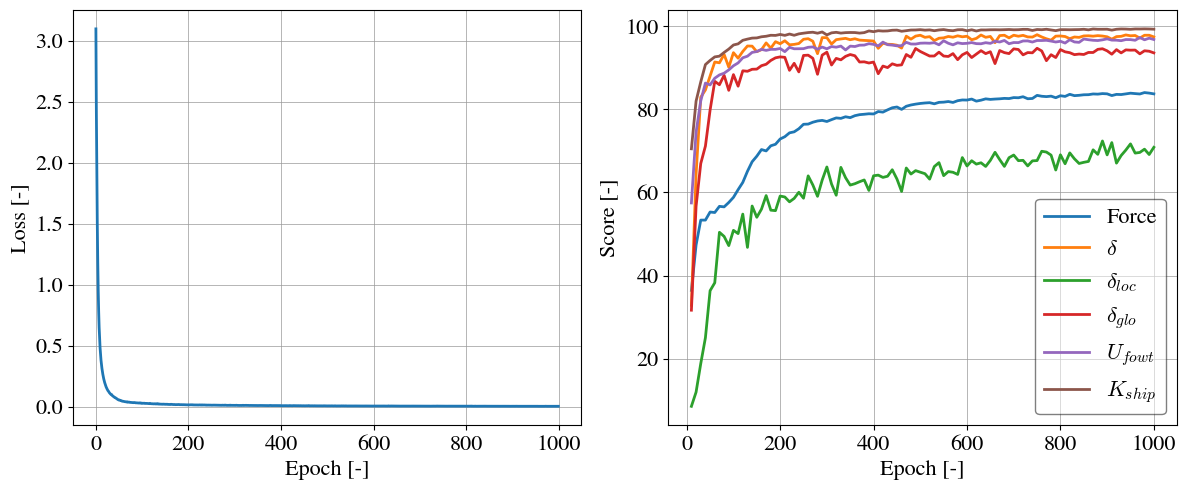

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.grid(color=(0.6, 0.6, 0.6), linewidth=0.5)
plt.plot(epoch_list)
plt.xlabel("Epoch [-]")
plt.ylabel("Loss [-]")

plt.subplot(122)
plt.grid(color=(0.6, 0.6, 0.6), linewidth=0.5)
plt.plot([(i+1) * 10 for i in range(int(num_epochs/10))], [item[0] for item in mape_list], label="Force")
plt.plot([(i+1) * 10 for i in range(int(num_epochs/10))], [item[1] for item in mape_list], label=r"$\delta$")
plt.plot([(i+1) * 10 for i in range(int(num_epochs/10))], [item[2] for item in mape_list], label=r"$\delta_{loc}$")
plt.plot([(i+1) * 10 for i in range(int(num_epochs/10))], [item[3] for item in mape_list], label=r"$\delta_{glo}$")
plt.plot([(i+1) * 10 for i in range(int(num_epochs/10))], [item[4] for item in mape_list], label=r"$U_{fowt}$")
plt.plot([(i+1) * 10 for i in range(int(num_epochs/10))], [item[5] for item in mape_list], label=r"$K_{ship}$")
plt.xlabel("Epoch [-]")
plt.ylabel("Score [-]")
plt.legend(loc="lower right", framealpha=0.5, edgecolor='black')

plt.tight_layout()
# plt.savefig('Convergence.pdf')
plt.show()

In [20]:
# mape_list = []
# for my_inputs, my_outputs in test_dataset:

#     outputs = model(my_inputs.unsqueeze(0))
#     outputs = low_pass_filter(outputs, fs = 2)

#     mape_error = mape(my_outputs, outputs[0][0])
#     # mape_list.append(mape_error)
#     print(mape_error)

#     my_inputs = denormalize_my_input(my_inputs)
#     outputs = denormalize_my_output(my_inputs, outputs[0][0])
#     my_outputs = denormalize_my_output(my_inputs, my_outputs)

#     print(my_inputs)

    

#     plot_results(my_outputs, output_dim_per_sequence, outputs)


In [23]:
# torch.save(model.state_dict(), 'model.pth')